# Landslide Detection From Sentinel-2 data

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import h5py
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
print("successfully imported required libraries")

successfully imported required libraries


### Visualize a sample data

In [3]:
# Testing the dataset 
path_single = r"\train\img\image_2000.h5"
path_single_mask = r'\train\mask\mask_2000.h5'

ls-> ['img']
input data shape: (128, 128, 14)
C:\Users\kaush\Desktop\Major_Project\Train\img
C:\Users\kaush\Desktop\Major_Project\Train\mask
ls ['mask']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


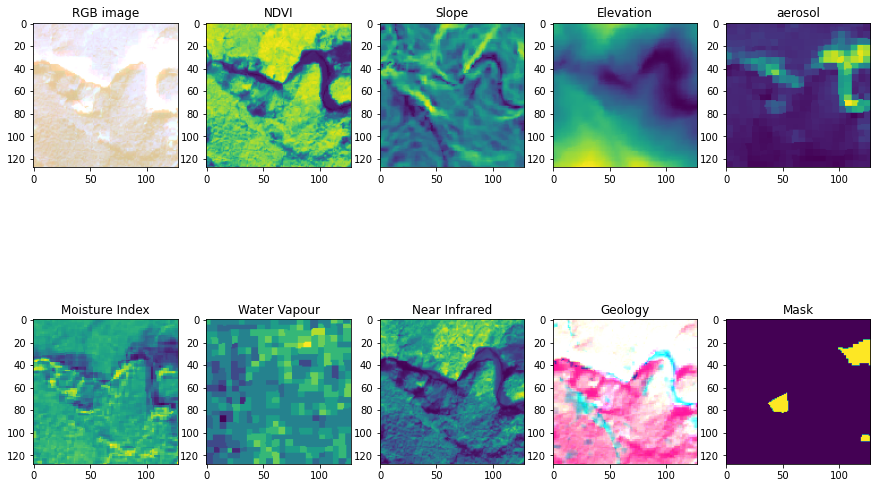

In [4]:
os.chdir("C:/Users/kaush/Desktop/Major_Project/Train/img")
with h5py.File("image_2000.h5") as hdf:
    ls = list(hdf.keys())
    print("ls->", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    data_red = data[:, :, 3]
    data_nir = data[:, :, 7]
    data_b8a = data[:, :, 8]
    data_11 = data[:, :, 11]
    data_moisture = np.divide(data_b8a - data_11,np.add(data_b8a, data_11))
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    data_geology = data[:,:,[12,11,2]]
    print(os.getcwd())
    os.chdir("../mask")
    print(os.getcwd())
    with h5py.File("../mask/mask_2000.h5") as hdf1:
        ls1 = list(hdf1.keys())
        print("ls", ls1)
        data_label = np.array(hdf1.get('mask'))

    fig,( (ax1,ax2, ax3, ax4, ax5),(ax6,ax7,ax8,ax9,ax10) )= plt.subplots(2,5,figsize=(15,10))
    ax1.set_title("RGB image")
    ax2.set_title("NDVI")
    ax3.set_title("Slope")
    ax4.set_title("Elevation")

    ax5.set_title("aerosol")
    ax6.set_title("Moisture Index")
    ax7.set_title("Water Vapour")
    ax8.set_title("Near Infrared")
    ax9.set_title("Geology")
    
    ax10.set_title("Mask")
    ax1.imshow(data[:, :, 0:3])
    ax2.imshow(data_ndvi)
    ax3.imshow(data[:, :, 12])
    ax4.imshow(data[:, :, 13])
    ax5.imshow(data[:, :, 0])
    ax6.imshow(data_moisture)
    ax7.imshow(data[:, :, 9])
    ax8.imshow(data[:, :, 7])
    ax9.imshow(data_geology)
    ax10.imshow(data_label)

## Training

### Preparing the dataset

In [5]:
print(os.getcwd())
os.chdir('C:/Users/kaush/Desktop/Major_Project')
print(os.getcwd())

C:\Users\kaush\Desktop\Major_Project\Train\mask
C:\Users\kaush\Desktop\Major_Project


In [27]:
path_single = r"Train/img/image_10.h5"
path_single_mask = r'Train/mask/mask_1.h5'
TRAIN_PATH = r"Train/img/*.h5"
TRAIN_MASK = r'Train/mask/*.h5'

TRAIN_XX = np.zeros((2500, 128, 128, 13))
TRAIN_YY = np.zeros((2500, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [28]:
print("strating")
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    if(i<2500):
        print("reading",i, img, mask)
        with h5py.File(img) as hdf:
            ls = list(hdf.keys()) 
            data = np.array(hdf.get('img'))

            # assign 0 for the nan value
            data[np.isnan(data)] = 0.000001

            data_red = data[:, :, 3]
            data_nir = data[:, :, 7]
            data_b8a = data[:, :, 8]
            data_11 = data[:, :, 11]
            data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red)) #ndvi calculation
            data_moisture = np.divide(data_b8a - data_11,np.add(data_b8a, data_11)) #moisture calculation
            data_geology = data[:,:,[12,11,2]]  #geology calculation

            # to normalize the data 
            mid_rgb = data[:, :, 1:4].max() / 2.0
            mid_slope = data[:, :, 12].max() / 2.0
            mid_elevation = data[:, :, 13].max() / 2.0
            mid_aerosol = data[:,:,0].max() / 2.0
            mid_watervapour = data[:,:,9].max() / 2.0
            mid_nir = data[:,:,7].max() / 2.0
            mid_geology = data_geology.max() / 2.0

            # final array
            TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
            TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
            TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
            TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
            TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
            TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

            TRAIN_XX[i, :, :, 6] = 1 - data[:, :, 0] / mid_aerosol #Aerosol
            TRAIN_XX[i, :, :, 7] = data_moisture #Moisture
            TRAIN_XX[i, :, :, 8] = 1 - data[:, :, 9] / mid_watervapour #Water Vapour
            TRAIN_XX[i, :, :, 9] = 1 - data[:, :, 7] / mid_nir #Near Infrared
            TRAIN_XX[i, :, :, 10] = 1 - data[:,:,12] / mid_geology #Geology
            TRAIN_XX[i, :, :, 11] = 1 - data[:,:,11] / mid_geology #Geology
            TRAIN_XX[i, :, :, 12] = 1 - data[:,:,2] / mid_geology #Geology
        with h5py.File(mask) as hdf:
            ls = list(hdf.keys())
            data=np.array(hdf.get('mask'))
            TRAIN_YY[i, :, :, 0] = data
    else:
        continue
print("completed")

strating
reading 0 Train/img\image_1.h5 Train/mask\mask_1.h5
reading 1 Train/img\image_10.h5 Train/mask\mask_10.h5
reading 2 Train/img\image_100.h5 Train/mask\mask_100.h5
reading 3 Train/img\image_1000.h5 Train/mask\mask_1000.h5
reading 4 Train/img\image_1001.h5 Train/mask\mask_1001.h5
reading 5 Train/img\image_1002.h5 Train/mask\mask_1002.h5
reading 6 Train/img\image_1003.h5 Train/mask\mask_1003.h5
reading 7 Train/img\image_1004.h5 Train/mask\mask_1004.h5
reading 8 Train/img\image_1005.h5 Train/mask\mask_1005.h5
reading 9 Train/img\image_1006.h5 Train/mask\mask_1006.h5
reading 10 Train/img\image_1007.h5 Train/mask\mask_1007.h5
reading 11 Train/img\image_1008.h5 Train/mask\mask_1008.h5
reading 12 Train/img\image_1009.h5 Train/mask\mask_1009.h5
reading 13 Train/img\image_101.h5 Train/mask\mask_101.h5
reading 14 Train/img\image_1010.h5 Train/mask\mask_1010.h5
reading 15 Train/img\image_1011.h5 Train/mask\mask_1011.h5
reading 16 Train/img\image_1012.h5 Train/mask\mask_1012.h5
reading 17 T

reading 141 Train/img\image_1125.h5 Train/mask\mask_1125.h5
reading 142 Train/img\image_1126.h5 Train/mask\mask_1126.h5
reading 143 Train/img\image_1127.h5 Train/mask\mask_1127.h5
reading 144 Train/img\image_1128.h5 Train/mask\mask_1128.h5
reading 145 Train/img\image_1129.h5 Train/mask\mask_1129.h5
reading 146 Train/img\image_113.h5 Train/mask\mask_113.h5
reading 147 Train/img\image_1130.h5 Train/mask\mask_1130.h5
reading 148 Train/img\image_1131.h5 Train/mask\mask_1131.h5
reading 149 Train/img\image_1132.h5 Train/mask\mask_1132.h5
reading 150 Train/img\image_1133.h5 Train/mask\mask_1133.h5
reading 151 Train/img\image_1134.h5 Train/mask\mask_1134.h5
reading 152 Train/img\image_1135.h5 Train/mask\mask_1135.h5
reading 153 Train/img\image_1136.h5 Train/mask\mask_1136.h5
reading 154 Train/img\image_1137.h5 Train/mask\mask_1137.h5
reading 155 Train/img\image_1138.h5 Train/mask\mask_1138.h5
reading 156 Train/img\image_1139.h5 Train/mask\mask_1139.h5
reading 157 Train/img\image_114.h5 Train/m

reading 280 Train/img\image_1250.h5 Train/mask\mask_1250.h5
reading 281 Train/img\image_1251.h5 Train/mask\mask_1251.h5
reading 282 Train/img\image_1252.h5 Train/mask\mask_1252.h5
reading 283 Train/img\image_1253.h5 Train/mask\mask_1253.h5
reading 284 Train/img\image_1254.h5 Train/mask\mask_1254.h5
reading 285 Train/img\image_1255.h5 Train/mask\mask_1255.h5
reading 286 Train/img\image_1256.h5 Train/mask\mask_1256.h5
reading 287 Train/img\image_1257.h5 Train/mask\mask_1257.h5
reading 288 Train/img\image_1258.h5 Train/mask\mask_1258.h5
reading 289 Train/img\image_1259.h5 Train/mask\mask_1259.h5
reading 290 Train/img\image_126.h5 Train/mask\mask_126.h5
reading 291 Train/img\image_1260.h5 Train/mask\mask_1260.h5
reading 292 Train/img\image_1261.h5 Train/mask\mask_1261.h5
reading 293 Train/img\image_1262.h5 Train/mask\mask_1262.h5
reading 294 Train/img\image_1263.h5 Train/mask\mask_1263.h5
reading 295 Train/img\image_1264.h5 Train/mask\mask_1264.h5
reading 296 Train/img\image_1265.h5 Train/

reading 418 Train/img\image_1375.h5 Train/mask\mask_1375.h5
reading 419 Train/img\image_1376.h5 Train/mask\mask_1376.h5
reading 420 Train/img\image_1377.h5 Train/mask\mask_1377.h5
reading 421 Train/img\image_1378.h5 Train/mask\mask_1378.h5
reading 422 Train/img\image_1379.h5 Train/mask\mask_1379.h5
reading 423 Train/img\image_138.h5 Train/mask\mask_138.h5
reading 424 Train/img\image_1380.h5 Train/mask\mask_1380.h5
reading 425 Train/img\image_1381.h5 Train/mask\mask_1381.h5
reading 426 Train/img\image_1382.h5 Train/mask\mask_1382.h5
reading 427 Train/img\image_1383.h5 Train/mask\mask_1383.h5
reading 428 Train/img\image_1384.h5 Train/mask\mask_1384.h5
reading 429 Train/img\image_1385.h5 Train/mask\mask_1385.h5
reading 430 Train/img\image_1386.h5 Train/mask\mask_1386.h5
reading 431 Train/img\image_1387.h5 Train/mask\mask_1387.h5
reading 432 Train/img\image_1388.h5 Train/mask\mask_1388.h5
reading 433 Train/img\image_1389.h5 Train/mask\mask_1389.h5
reading 434 Train/img\image_139.h5 Train/m

reading 559 Train/img\image_1501.h5 Train/mask\mask_1501.h5
reading 560 Train/img\image_1502.h5 Train/mask\mask_1502.h5
reading 561 Train/img\image_1503.h5 Train/mask\mask_1503.h5
reading 562 Train/img\image_1504.h5 Train/mask\mask_1504.h5
reading 563 Train/img\image_1505.h5 Train/mask\mask_1505.h5
reading 564 Train/img\image_1506.h5 Train/mask\mask_1506.h5
reading 565 Train/img\image_1507.h5 Train/mask\mask_1507.h5
reading 566 Train/img\image_1508.h5 Train/mask\mask_1508.h5
reading 567 Train/img\image_1509.h5 Train/mask\mask_1509.h5
reading 568 Train/img\image_151.h5 Train/mask\mask_151.h5
reading 569 Train/img\image_1510.h5 Train/mask\mask_1510.h5
reading 570 Train/img\image_1511.h5 Train/mask\mask_1511.h5
reading 571 Train/img\image_1512.h5 Train/mask\mask_1512.h5
reading 572 Train/img\image_1513.h5 Train/mask\mask_1513.h5
reading 573 Train/img\image_1514.h5 Train/mask\mask_1514.h5
reading 574 Train/img\image_1515.h5 Train/mask\mask_1515.h5
reading 575 Train/img\image_1516.h5 Train/

reading 701 Train/img\image_163.h5 Train/mask\mask_163.h5
reading 702 Train/img\image_1630.h5 Train/mask\mask_1630.h5
reading 703 Train/img\image_1631.h5 Train/mask\mask_1631.h5
reading 704 Train/img\image_1632.h5 Train/mask\mask_1632.h5
reading 705 Train/img\image_1633.h5 Train/mask\mask_1633.h5
reading 706 Train/img\image_1634.h5 Train/mask\mask_1634.h5
reading 707 Train/img\image_1635.h5 Train/mask\mask_1635.h5
reading 708 Train/img\image_1636.h5 Train/mask\mask_1636.h5
reading 709 Train/img\image_1637.h5 Train/mask\mask_1637.h5
reading 710 Train/img\image_1638.h5 Train/mask\mask_1638.h5
reading 711 Train/img\image_1639.h5 Train/mask\mask_1639.h5
reading 712 Train/img\image_164.h5 Train/mask\mask_164.h5
reading 713 Train/img\image_1640.h5 Train/mask\mask_1640.h5
reading 714 Train/img\image_1641.h5 Train/mask\mask_1641.h5
reading 715 Train/img\image_1642.h5 Train/mask\mask_1642.h5
reading 716 Train/img\image_1643.h5 Train/mask\mask_1643.h5
reading 717 Train/img\image_1644.h5 Train/ma

reading 848 Train/img\image_1762.h5 Train/mask\mask_1762.h5
reading 849 Train/img\image_1763.h5 Train/mask\mask_1763.h5
reading 850 Train/img\image_1764.h5 Train/mask\mask_1764.h5
reading 851 Train/img\image_1765.h5 Train/mask\mask_1765.h5
reading 852 Train/img\image_1766.h5 Train/mask\mask_1766.h5
reading 853 Train/img\image_1767.h5 Train/mask\mask_1767.h5
reading 854 Train/img\image_1768.h5 Train/mask\mask_1768.h5
reading 855 Train/img\image_1769.h5 Train/mask\mask_1769.h5
reading 856 Train/img\image_177.h5 Train/mask\mask_177.h5
reading 857 Train/img\image_1770.h5 Train/mask\mask_1770.h5
reading 858 Train/img\image_1771.h5 Train/mask\mask_1771.h5
reading 859 Train/img\image_1772.h5 Train/mask\mask_1772.h5
reading 860 Train/img\image_1773.h5 Train/mask\mask_1773.h5
reading 861 Train/img\image_1774.h5 Train/mask\mask_1774.h5
reading 862 Train/img\image_1775.h5 Train/mask\mask_1775.h5
reading 863 Train/img\image_1776.h5 Train/mask\mask_1776.h5
reading 864 Train/img\image_1777.h5 Train/

reading 996 Train/img\image_1896.h5 Train/mask\mask_1896.h5
reading 997 Train/img\image_1897.h5 Train/mask\mask_1897.h5
reading 998 Train/img\image_1898.h5 Train/mask\mask_1898.h5
reading 999 Train/img\image_1899.h5 Train/mask\mask_1899.h5
reading 1000 Train/img\image_19.h5 Train/mask\mask_19.h5
reading 1001 Train/img\image_190.h5 Train/mask\mask_190.h5
reading 1002 Train/img\image_1900.h5 Train/mask\mask_1900.h5
reading 1003 Train/img\image_1901.h5 Train/mask\mask_1901.h5
reading 1004 Train/img\image_1902.h5 Train/mask\mask_1902.h5
reading 1005 Train/img\image_1903.h5 Train/mask\mask_1903.h5
reading 1006 Train/img\image_1904.h5 Train/mask\mask_1904.h5
reading 1007 Train/img\image_1905.h5 Train/mask\mask_1905.h5
reading 1008 Train/img\image_1906.h5 Train/mask\mask_1906.h5
reading 1009 Train/img\image_1907.h5 Train/mask\mask_1907.h5
reading 1010 Train/img\image_1908.h5 Train/mask\mask_1908.h5
reading 1011 Train/img\image_1909.h5 Train/mask\mask_1909.h5
reading 1012 Train/img\image_191.h

reading 1140 Train/img\image_2024.h5 Train/mask\mask_2024.h5
reading 1141 Train/img\image_2025.h5 Train/mask\mask_2025.h5
reading 1142 Train/img\image_2026.h5 Train/mask\mask_2026.h5
reading 1143 Train/img\image_2027.h5 Train/mask\mask_2027.h5
reading 1144 Train/img\image_2028.h5 Train/mask\mask_2028.h5
reading 1145 Train/img\image_2029.h5 Train/mask\mask_2029.h5
reading 1146 Train/img\image_203.h5 Train/mask\mask_203.h5
reading 1147 Train/img\image_2030.h5 Train/mask\mask_2030.h5
reading 1148 Train/img\image_2031.h5 Train/mask\mask_2031.h5
reading 1149 Train/img\image_2032.h5 Train/mask\mask_2032.h5
reading 1150 Train/img\image_2033.h5 Train/mask\mask_2033.h5
reading 1151 Train/img\image_2034.h5 Train/mask\mask_2034.h5
reading 1152 Train/img\image_2035.h5 Train/mask\mask_2035.h5
reading 1153 Train/img\image_2036.h5 Train/mask\mask_2036.h5
reading 1154 Train/img\image_2037.h5 Train/mask\mask_2037.h5
reading 1155 Train/img\image_2038.h5 Train/mask\mask_2038.h5
reading 1156 Train/img\ima

reading 1287 Train/img\image_2157.h5 Train/mask\mask_2157.h5
reading 1288 Train/img\image_2158.h5 Train/mask\mask_2158.h5
reading 1289 Train/img\image_2159.h5 Train/mask\mask_2159.h5
reading 1290 Train/img\image_216.h5 Train/mask\mask_216.h5
reading 1291 Train/img\image_2160.h5 Train/mask\mask_2160.h5
reading 1292 Train/img\image_2161.h5 Train/mask\mask_2161.h5
reading 1293 Train/img\image_2162.h5 Train/mask\mask_2162.h5
reading 1294 Train/img\image_2163.h5 Train/mask\mask_2163.h5
reading 1295 Train/img\image_2164.h5 Train/mask\mask_2164.h5
reading 1296 Train/img\image_2165.h5 Train/mask\mask_2165.h5
reading 1297 Train/img\image_2166.h5 Train/mask\mask_2166.h5
reading 1298 Train/img\image_2167.h5 Train/mask\mask_2167.h5
reading 1299 Train/img\image_2168.h5 Train/mask\mask_2168.h5
reading 1300 Train/img\image_2169.h5 Train/mask\mask_2169.h5
reading 1301 Train/img\image_217.h5 Train/mask\mask_217.h5
reading 1302 Train/img\image_2170.h5 Train/mask\mask_2170.h5
reading 1303 Train/img\image

reading 1430 Train/img\image_2286.h5 Train/mask\mask_2286.h5
reading 1431 Train/img\image_2287.h5 Train/mask\mask_2287.h5
reading 1432 Train/img\image_2288.h5 Train/mask\mask_2288.h5
reading 1433 Train/img\image_2289.h5 Train/mask\mask_2289.h5
reading 1434 Train/img\image_229.h5 Train/mask\mask_229.h5
reading 1435 Train/img\image_2290.h5 Train/mask\mask_2290.h5
reading 1436 Train/img\image_2291.h5 Train/mask\mask_2291.h5
reading 1437 Train/img\image_2292.h5 Train/mask\mask_2292.h5
reading 1438 Train/img\image_2293.h5 Train/mask\mask_2293.h5
reading 1439 Train/img\image_2294.h5 Train/mask\mask_2294.h5
reading 1440 Train/img\image_2295.h5 Train/mask\mask_2295.h5
reading 1441 Train/img\image_2296.h5 Train/mask\mask_2296.h5
reading 1442 Train/img\image_2297.h5 Train/mask\mask_2297.h5
reading 1443 Train/img\image_2298.h5 Train/mask\mask_2298.h5
reading 1444 Train/img\image_2299.h5 Train/mask\mask_2299.h5
reading 1445 Train/img\image_23.h5 Train/mask\mask_23.h5
reading 1446 Train/img\image_2

reading 1566 Train/img\image_2408.h5 Train/mask\mask_2408.h5
reading 1567 Train/img\image_2409.h5 Train/mask\mask_2409.h5
reading 1568 Train/img\image_241.h5 Train/mask\mask_241.h5
reading 1569 Train/img\image_2410.h5 Train/mask\mask_2410.h5
reading 1570 Train/img\image_2411.h5 Train/mask\mask_2411.h5
reading 1571 Train/img\image_2412.h5 Train/mask\mask_2412.h5
reading 1572 Train/img\image_2413.h5 Train/mask\mask_2413.h5
reading 1573 Train/img\image_2414.h5 Train/mask\mask_2414.h5
reading 1574 Train/img\image_2415.h5 Train/mask\mask_2415.h5
reading 1575 Train/img\image_2416.h5 Train/mask\mask_2416.h5
reading 1576 Train/img\image_2417.h5 Train/mask\mask_2417.h5
reading 1577 Train/img\image_2418.h5 Train/mask\mask_2418.h5
reading 1578 Train/img\image_2419.h5 Train/mask\mask_2419.h5
reading 1579 Train/img\image_242.h5 Train/mask\mask_242.h5
reading 1580 Train/img\image_2420.h5 Train/mask\mask_2420.h5
reading 1581 Train/img\image_2421.h5 Train/mask\mask_2421.h5
reading 1582 Train/img\image

C:\Users\kaush\AppData\Local\Temp\ipykernel_12936\3875164637.py:34: RuntimeWarning: invalid value encountered in true_divide
  TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE


reading 1670 Train/img\image_2501.h5 Train/mask\mask_2501.h5
reading 1671 Train/img\image_2502.h5 Train/mask\mask_2502.h5
reading 1672 Train/img\image_2503.h5 Train/mask\mask_2503.h5
reading 1673 Train/img\image_2504.h5 Train/mask\mask_2504.h5
reading 1674 Train/img\image_2505.h5 Train/mask\mask_2505.h5
reading 1675 Train/img\image_2506.h5 Train/mask\mask_2506.h5
reading 1676 Train/img\image_2507.h5 Train/mask\mask_2507.h5
reading 1677 Train/img\image_2508.h5 Train/mask\mask_2508.h5
reading 1678 Train/img\image_2509.h5 Train/mask\mask_2509.h5
reading 1679 Train/img\image_251.h5 Train/mask\mask_251.h5
reading 1680 Train/img\image_2510.h5 Train/mask\mask_2510.h5
reading 1681 Train/img\image_2511.h5 Train/mask\mask_2511.h5
reading 1682 Train/img\image_2512.h5 Train/mask\mask_2512.h5
reading 1683 Train/img\image_2513.h5 Train/mask\mask_2513.h5
reading 1684 Train/img\image_2514.h5 Train/mask\mask_2514.h5
reading 1685 Train/img\image_2515.h5 Train/mask\mask_2515.h5
reading 1686 Train/img\ima

reading 1810 Train/img\image_2628.h5 Train/mask\mask_2628.h5
reading 1811 Train/img\image_2629.h5 Train/mask\mask_2629.h5
reading 1812 Train/img\image_263.h5 Train/mask\mask_263.h5
reading 1813 Train/img\image_2630.h5 Train/mask\mask_2630.h5
reading 1814 Train/img\image_2631.h5 Train/mask\mask_2631.h5
reading 1815 Train/img\image_2632.h5 Train/mask\mask_2632.h5
reading 1816 Train/img\image_2633.h5 Train/mask\mask_2633.h5
reading 1817 Train/img\image_2634.h5 Train/mask\mask_2634.h5
reading 1818 Train/img\image_2635.h5 Train/mask\mask_2635.h5
reading 1819 Train/img\image_2636.h5 Train/mask\mask_2636.h5
reading 1820 Train/img\image_2637.h5 Train/mask\mask_2637.h5
reading 1821 Train/img\image_2638.h5 Train/mask\mask_2638.h5
reading 1822 Train/img\image_2639.h5 Train/mask\mask_2639.h5
reading 1823 Train/img\image_264.h5 Train/mask\mask_264.h5
reading 1824 Train/img\image_2640.h5 Train/mask\mask_2640.h5
reading 1825 Train/img\image_2641.h5 Train/mask\mask_2641.h5
reading 1826 Train/img\image

reading 1954 Train/img\image_2758.h5 Train/mask\mask_2758.h5
reading 1955 Train/img\image_2759.h5 Train/mask\mask_2759.h5
reading 1956 Train/img\image_276.h5 Train/mask\mask_276.h5
reading 1957 Train/img\image_2760.h5 Train/mask\mask_2760.h5
reading 1958 Train/img\image_2761.h5 Train/mask\mask_2761.h5
reading 1959 Train/img\image_2762.h5 Train/mask\mask_2762.h5
reading 1960 Train/img\image_2763.h5 Train/mask\mask_2763.h5
reading 1961 Train/img\image_2764.h5 Train/mask\mask_2764.h5
reading 1962 Train/img\image_2765.h5 Train/mask\mask_2765.h5
reading 1963 Train/img\image_2766.h5 Train/mask\mask_2766.h5
reading 1964 Train/img\image_2767.h5 Train/mask\mask_2767.h5
reading 1965 Train/img\image_2768.h5 Train/mask\mask_2768.h5
reading 1966 Train/img\image_2769.h5 Train/mask\mask_2769.h5
reading 1967 Train/img\image_277.h5 Train/mask\mask_277.h5
reading 1968 Train/img\image_2770.h5 Train/mask\mask_2770.h5
reading 1969 Train/img\image_2771.h5 Train/mask\mask_2771.h5
reading 1970 Train/img\image

reading 2089 Train/img\image_288.h5 Train/mask\mask_288.h5
reading 2090 Train/img\image_2880.h5 Train/mask\mask_2880.h5
reading 2091 Train/img\image_2881.h5 Train/mask\mask_2881.h5
reading 2092 Train/img\image_2882.h5 Train/mask\mask_2882.h5
reading 2093 Train/img\image_2883.h5 Train/mask\mask_2883.h5
reading 2094 Train/img\image_2884.h5 Train/mask\mask_2884.h5
reading 2095 Train/img\image_2885.h5 Train/mask\mask_2885.h5
reading 2096 Train/img\image_2886.h5 Train/mask\mask_2886.h5
reading 2097 Train/img\image_2887.h5 Train/mask\mask_2887.h5
reading 2098 Train/img\image_2888.h5 Train/mask\mask_2888.h5
reading 2099 Train/img\image_2889.h5 Train/mask\mask_2889.h5
reading 2100 Train/img\image_289.h5 Train/mask\mask_289.h5
reading 2101 Train/img\image_2890.h5 Train/mask\mask_2890.h5
reading 2102 Train/img\image_2891.h5 Train/mask\mask_2891.h5
reading 2103 Train/img\image_2892.h5 Train/mask\mask_2892.h5
reading 2104 Train/img\image_2893.h5 Train/mask\mask_2893.h5
reading 2105 Train/img\image

reading 2230 Train/img\image_3005.h5 Train/mask\mask_3005.h5
reading 2231 Train/img\image_3006.h5 Train/mask\mask_3006.h5
reading 2232 Train/img\image_3007.h5 Train/mask\mask_3007.h5
reading 2233 Train/img\image_3008.h5 Train/mask\mask_3008.h5
reading 2234 Train/img\image_3009.h5 Train/mask\mask_3009.h5
reading 2235 Train/img\image_301.h5 Train/mask\mask_301.h5
reading 2236 Train/img\image_3010.h5 Train/mask\mask_3010.h5
reading 2237 Train/img\image_3011.h5 Train/mask\mask_3011.h5
reading 2238 Train/img\image_3012.h5 Train/mask\mask_3012.h5
reading 2239 Train/img\image_3013.h5 Train/mask\mask_3013.h5
reading 2240 Train/img\image_3014.h5 Train/mask\mask_3014.h5
reading 2241 Train/img\image_3015.h5 Train/mask\mask_3015.h5
reading 2242 Train/img\image_3016.h5 Train/mask\mask_3016.h5
reading 2243 Train/img\image_3017.h5 Train/mask\mask_3017.h5
reading 2244 Train/img\image_3018.h5 Train/mask\mask_3018.h5
reading 2245 Train/img\image_3019.h5 Train/mask\mask_3019.h5
reading 2246 Train/img\ima

C:\Users\kaush\AppData\Local\Temp\ipykernel_12936\3875164637.py:16: RuntimeWarning: invalid value encountered in true_divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red)) #ndvi calculation
C:\Users\kaush\AppData\Local\Temp\ipykernel_12936\3875164637.py:17: RuntimeWarning: invalid value encountered in true_divide
  data_moisture = np.divide(data_b8a - data_11,np.add(data_b8a, data_11)) #moisture calculation


reading 2264 Train/img\image_3036.h5 Train/mask\mask_3036.h5
reading 2265 Train/img\image_3037.h5 Train/mask\mask_3037.h5
reading 2266 Train/img\image_3038.h5 Train/mask\mask_3038.h5
reading 2267 Train/img\image_3039.h5 Train/mask\mask_3039.h5
reading 2268 Train/img\image_304.h5 Train/mask\mask_304.h5
reading 2269 Train/img\image_3040.h5 Train/mask\mask_3040.h5
reading 2270 Train/img\image_3041.h5 Train/mask\mask_3041.h5
reading 2271 Train/img\image_3042.h5 Train/mask\mask_3042.h5
reading 2272 Train/img\image_3043.h5 Train/mask\mask_3043.h5
reading 2273 Train/img\image_3044.h5 Train/mask\mask_3044.h5
reading 2274 Train/img\image_3045.h5 Train/mask\mask_3045.h5
reading 2275 Train/img\image_3046.h5 Train/mask\mask_3046.h5
reading 2276 Train/img\image_3047.h5 Train/mask\mask_3047.h5
reading 2277 Train/img\image_3048.h5 Train/mask\mask_3048.h5
reading 2278 Train/img\image_3049.h5 Train/mask\mask_3049.h5
reading 2279 Train/img\image_305.h5 Train/mask\mask_305.h5
reading 2280 Train/img\image

reading 2403 Train/img\image_3161.h5 Train/mask\mask_3161.h5
reading 2404 Train/img\image_3162.h5 Train/mask\mask_3162.h5
reading 2405 Train/img\image_3163.h5 Train/mask\mask_3163.h5
reading 2406 Train/img\image_3164.h5 Train/mask\mask_3164.h5
reading 2407 Train/img\image_3165.h5 Train/mask\mask_3165.h5
reading 2408 Train/img\image_3166.h5 Train/mask\mask_3166.h5
reading 2409 Train/img\image_3167.h5 Train/mask\mask_3167.h5
reading 2410 Train/img\image_3168.h5 Train/mask\mask_3168.h5
reading 2411 Train/img\image_3169.h5 Train/mask\mask_3169.h5
reading 2412 Train/img\image_317.h5 Train/mask\mask_317.h5
reading 2413 Train/img\image_3170.h5 Train/mask\mask_3170.h5
reading 2414 Train/img\image_3171.h5 Train/mask\mask_3171.h5
reading 2415 Train/img\image_3172.h5 Train/mask\mask_3172.h5
reading 2416 Train/img\image_3173.h5 Train/mask\mask_3173.h5
reading 2417 Train/img\image_3174.h5 Train/mask\mask_3174.h5
reading 2418 Train/img\image_3175.h5 Train/mask\mask_3175.h5
reading 2419 Train/img\ima

In [29]:
# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


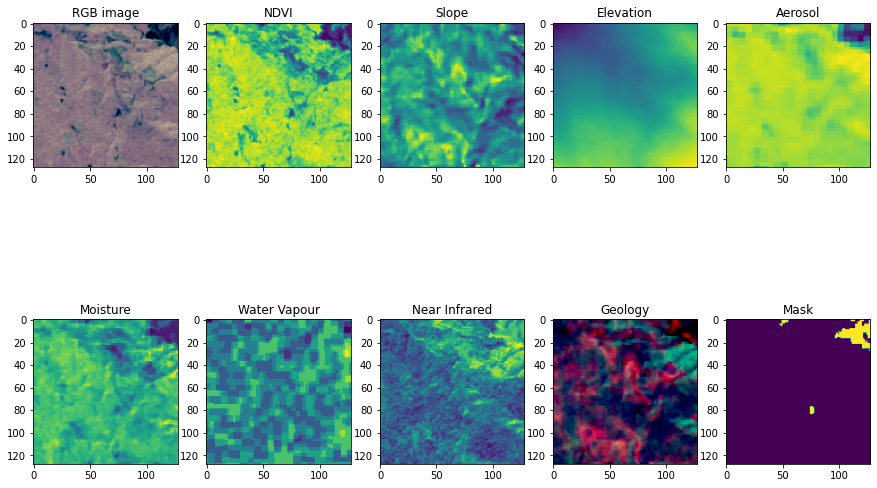

In [30]:
img=216
fig,((ax1,ax2, ax3, ax4, ax5),(ax6,ax7,ax8,ax9,ax10))= plt.subplots(2,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Aerosol")
ax6.set_title("Moisture")
ax7.set_title("Water Vapour")
ax8.set_title("Near Infrared")
ax9.set_title("Geology")
ax10.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_XX[img, :, :, 6])
ax6.imshow(TRAIN_XX[img, :, :, 7])
ax7.imshow(TRAIN_XX[img, :, :, 8])
ax8.imshow(TRAIN_XX[img, :, :, 9])
ax9.imshow(TRAIN_XX[img, :, :, 10:13])
ax10.imshow(TRAIN_YY[img, :, :, 0])

In [31]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


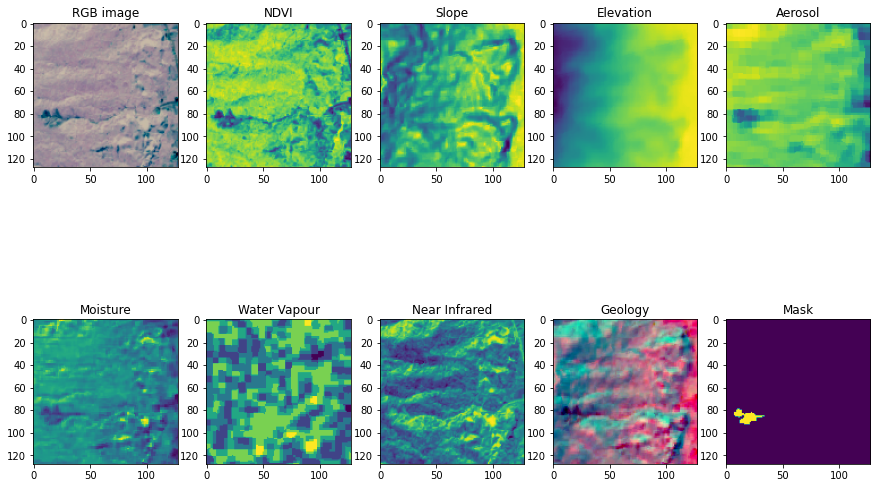

In [36]:
img=203
fig,((ax1,ax2, ax3, ax4, ax5),(ax6,ax7,ax8,ax9,ax10))= plt.subplots(2,5,figsize=(15,10))
ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Aerosol")
ax6.set_title("Moisture")
ax7.set_title("Water Vapour")
ax8.set_title("Near Infrared")
ax9.set_title("Geology")
ax10.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(x_train[img, :, :, 6])
ax6.imshow(x_train[img, :, :, 7])
ax7.imshow(x_train[img, :, :, 8])
ax8.imshow(x_train[img, :, :, 9])
ax9.imshow(x_train[img, :, :, 10:13])
ax10.imshow(y_train[img, :, :, 0])

In [37]:
x_train.shape, y_train.shape

((2000, 128, 128, 13), (2000, 128, 128, 1))

In [38]:
# to release some memory, delete the unnecessary variable
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask 

### Model Metrics

In [39]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator
  
def custom_loss_function(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

### Unet Model

In [40]:
#from utils import recall_m, precision_m, f1_m
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m, dice_loss, custom_loss_function])
    
    return model

### Train with Unet Model

In [42]:
model = unet_model(128, 128, 13)
# model.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
#earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')


callbacks = [
    #earlyStopping,
    checkpointer
    ]
history = model.fit(x_train, y_train, batch_size=32,  
          epochs=60, 
          verbose = 2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

model.save("model_save.h5")

Epoch 1/60

Epoch 1: val_f1_m improved from -inf to 0.21392, saving model to best_model.h5
63/63 - 152s - loss: 0.1135 - accuracy: 0.9581 - f1_m: 0.0192 - precision_m: 0.2887 - recall_m: 0.0235 - dice_loss: 0.9489 - custom_loss_function: 0.0297 - val_loss: 0.0575 - val_accuracy: 0.9776 - val_f1_m: 0.2139 - val_precision_m: 0.7121 - val_recall_m: 0.1291 - val_dice_loss: 0.9480 - val_custom_loss_function: 0.0162 - 152s/epoch - 2s/step
Epoch 2/60

Epoch 2: val_f1_m improved from 0.21392 to 0.58720, saving model to best_model.h5
63/63 - 143s - loss: 0.0510 - accuracy: 0.9807 - f1_m: 0.4677 - precision_m: 0.7498 - recall_m: 0.3654 - dice_loss: 0.9437 - custom_loss_function: 0.0145 - val_loss: 0.0481 - val_accuracy: 0.9814 - val_f1_m: 0.5872 - val_precision_m: 0.6276 - val_recall_m: 0.5626 - val_dice_loss: 0.9444 - val_custom_loss_function: 0.0138 - 143s/epoch - 2s/step
Epoch 3/60

Epoch 3: val_f1_m improved from 0.58720 to 0.61338, saving model to best_model.h5
63/63 - 142s - loss: 0.0449 -

Epoch 21/60

Epoch 21: val_f1_m did not improve from 0.69808
63/63 - 141s - loss: 0.0314 - accuracy: 0.9873 - f1_m: 0.7150 - precision_m: 0.7998 - recall_m: 0.6509 - dice_loss: 0.9382 - custom_loss_function: 0.0093 - val_loss: 0.0327 - val_accuracy: 0.9871 - val_f1_m: 0.6979 - val_precision_m: 0.7744 - val_recall_m: 0.6389 - val_dice_loss: 0.9413 - val_custom_loss_function: 0.0096 - 141s/epoch - 2s/step
Epoch 22/60

Epoch 22: val_f1_m did not improve from 0.69808
63/63 - 141s - loss: 0.0312 - accuracy: 0.9873 - f1_m: 0.7198 - precision_m: 0.7925 - recall_m: 0.6626 - dice_loss: 0.9381 - custom_loss_function: 0.0092 - val_loss: 0.0324 - val_accuracy: 0.9871 - val_f1_m: 0.6829 - val_precision_m: 0.8059 - val_recall_m: 0.5957 - val_dice_loss: 0.9418 - val_custom_loss_function: 0.0095 - 141s/epoch - 2s/step
Epoch 23/60

Epoch 23: val_f1_m improved from 0.69808 to 0.70489, saving model to best_model.h5
63/63 - 141s - loss: 0.0308 - accuracy: 0.9875 - f1_m: 0.7241 - precision_m: 0.8049 - reca

63/63 - 142s - loss: 0.0256 - accuracy: 0.9894 - f1_m: 0.7736 - precision_m: 0.8206 - recall_m: 0.7338 - dice_loss: 0.9367 - custom_loss_function: 0.0077 - val_loss: 0.0341 - val_accuracy: 0.9869 - val_f1_m: 0.6918 - val_precision_m: 0.7736 - val_recall_m: 0.6300 - val_dice_loss: 0.9413 - val_custom_loss_function: 0.0097 - 142s/epoch - 2s/step
Epoch 42/60

Epoch 42: val_f1_m did not improve from 0.70489
63/63 - 151s - loss: 0.0250 - accuracy: 0.9896 - f1_m: 0.7781 - precision_m: 0.8242 - recall_m: 0.7384 - dice_loss: 0.9370 - custom_loss_function: 0.0075 - val_loss: 0.0338 - val_accuracy: 0.9872 - val_f1_m: 0.6949 - val_precision_m: 0.7825 - val_recall_m: 0.6283 - val_dice_loss: 0.9414 - val_custom_loss_function: 0.0096 - 151s/epoch - 2s/step
Epoch 43/60

Epoch 43: val_f1_m did not improve from 0.70489
63/63 - 144s - loss: 0.0247 - accuracy: 0.9897 - f1_m: 0.7829 - precision_m: 0.8267 - recall_m: 0.7453 - dice_loss: 0.9362 - custom_loss_function: 0.0074 - val_loss: 0.0346 - val_accurac

### Evaluation

In [43]:
loss, accuracy, f1_score, precision, recall,dice_loss,custom_loss_function = model.evaluate(x_valid, y_valid, verbose=0)
print(loss, accuracy, f1_score, precision, recall,dice_loss,custom_loss_function)

0.0407768115401268 0.9867734313011169 0.6747051477432251 0.7899456024169922 0.5929204225540161 0.9417919516563416 0.01023983582854271


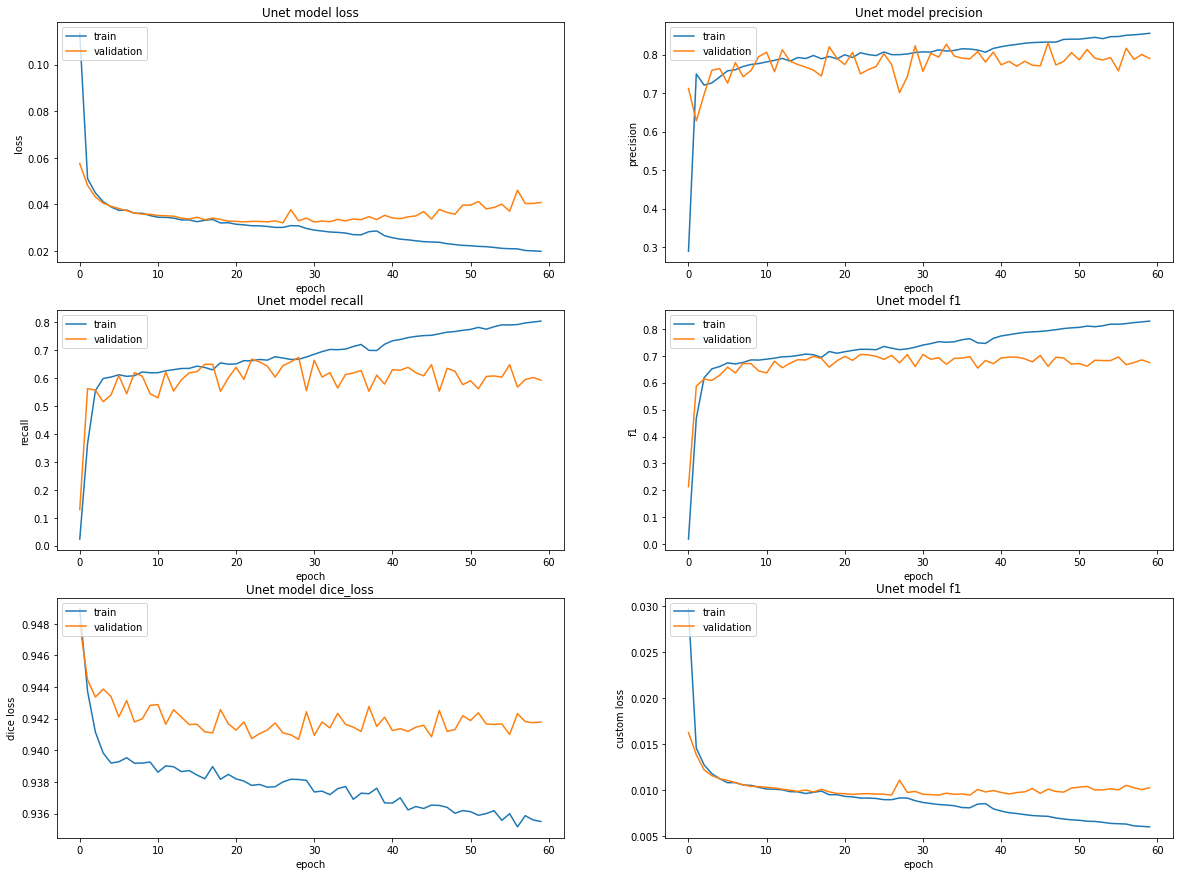

In [45]:
fig,((ax11,ax12),(ax13,ax14),(ax15,ax16)) = plt.subplots(3,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

ax15.plot(history.history['dice_loss'])
ax15.plot(history.history['val_dice_loss'])
ax15.set_title('Unet model dice_loss')
ax15.set_ylabel('dice loss')
ax15.set_xlabel('epoch')
ax15.legend(['train', 'validation'], loc='upper left')

ax16.plot(history.history['custom_loss_function'])
ax16.plot(history.history['val_custom_loss_function'])
ax16.set_title('Unet model f1')
ax16.set_ylabel('custom loss')
ax16.set_xlabel('epoch')
ax16.legend(['train', 'validation'], loc='upper left')

### Testing

In [76]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Image')

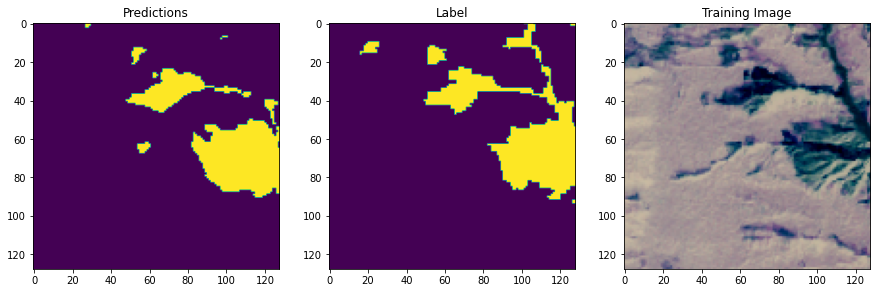

In [77]:
img = 175
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')
#155,140 can be used

### Validation

In [82]:
validation_url = r"img/*.h5"
print(os.getcwd())
img_val = sorted(glob.glob(validation_url))
print(img_val)
VAL_XX = np.zeros((245, 128, 128, 13))
mask_name = []
for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001 

        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_b8a = data[:, :, 8]
        data_11 = data[:, :, 11]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red)) #ndvi calculation
        data_moisture = np.divide(data_b8a - data_11,np.add(data_b8a, data_11)) #moisture calculation
        data_geology = data[:,:,[12,11,2]]  #geology calculation

            # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0
        mid_aerosol = data[:,:,0].max() / 2.0
        mid_watervapour = data[:,:,9].max() / 2.0
        mid_nir = data[:,:,7].max() / 2.0
        mid_geology = data_geology.max() / 2.0

            # final array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        VAL_XX[i, :, :, 3] = data_ndvi #NDVI
        VAL_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

        VAL_XX[i, :, :, 6] = 1 - data[:, :, 0] / mid_aerosol #Aerosol
        VAL_XX[i, :, :, 7] = data_moisture #Moisture
        VAL_XX[i, :, :, 8] = 1 - data[:, :, 9] / mid_watervapour #Water Vapour
        VAL_XX[i, :, :, 9] = 1 - data[:, :, 7] / mid_nir #Near Infrared
        VAL_XX[i, :, :, 10] = 1 - data[:,:,12] / mid_geology #Geology
        VAL_XX[i, :, :, 11] = 1 - data[:,:,11] / mid_geology #Geology
        VAL_XX[i, :, :, 12] = 1 - data[:,:,2] / mid_geology #Geology
print("completed")

C:\Users\kaush\Desktop\Major_Project\Valid
['img\\image_1.h5', 'img\\image_10.h5', 'img\\image_100.h5', 'img\\image_101.h5', 'img\\image_102.h5', 'img\\image_103.h5', 'img\\image_104.h5', 'img\\image_105.h5', 'img\\image_106.h5', 'img\\image_107.h5', 'img\\image_108.h5', 'img\\image_109.h5', 'img\\image_11.h5', 'img\\image_110.h5', 'img\\image_111.h5', 'img\\image_112.h5', 'img\\image_113.h5', 'img\\image_114.h5', 'img\\image_115.h5', 'img\\image_116.h5', 'img\\image_117.h5', 'img\\image_118.h5', 'img\\image_119.h5', 'img\\image_12.h5', 'img\\image_120.h5', 'img\\image_121.h5', 'img\\image_122.h5', 'img\\image_123.h5', 'img\\image_124.h5', 'img\\image_125.h5', 'img\\image_126.h5', 'img\\image_127.h5', 'img\\image_128.h5', 'img\\image_129.h5', 'img\\image_13.h5', 'img\\image_130.h5', 'img\\image_131.h5', 'img\\image_132.h5', 'img\\image_133.h5', 'img\\image_134.h5', 'img\\image_135.h5', 'img\\image_136.h5', 'img\\image_137.h5', 'img\\image_138.h5', 'img\\image_139.h5', 'img\\image_14.h5

C:\Users\kaush\AppData\Local\Temp\ipykernel_12936\1522533810.py:21: RuntimeWarning: invalid value encountered in true_divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red)) #ndvi calculation
C:\Users\kaush\AppData\Local\Temp\ipykernel_12936\1522533810.py:22: RuntimeWarning: invalid value encountered in true_divide
  data_moisture = np.divide(data_b8a - data_11,np.add(data_b8a, data_11)) #moisture calculation


162 img\image_245.h5
163 img\image_25.h5
164 img\image_26.h5
165 img\image_27.h5
166 img\image_28.h5
167 img\image_29.h5
168 img\image_3.h5
169 img\image_30.h5
170 img\image_31.h5
171 img\image_32.h5
172 img\image_33.h5
173 img\image_34.h5
174 img\image_35.h5
175 img\image_36.h5
176 img\image_37.h5
177 img\image_38.h5
178 img\image_39.h5
179 img\image_4.h5
180 img\image_40.h5
181 img\image_41.h5
182 img\image_42.h5
183 img\image_43.h5
184 img\image_44.h5
185 img\image_45.h5
186 img\image_46.h5
187 img\image_47.h5
188 img\image_48.h5
189 img\image_49.h5
190 img\image_5.h5
191 img\image_50.h5
192 img\image_51.h5
193 img\image_52.h5
194 img\image_53.h5
195 img\image_54.h5
196 img\image_55.h5
197 img\image_56.h5
198 img\image_57.h5
199 img\image_58.h5
200 img\image_59.h5
201 img\image_6.h5
202 img\image_60.h5
203 img\image_61.h5
204 img\image_62.h5
205 img\image_63.h5
206 img\image_64.h5
207 img\image_65.h5
208 img\image_66.h5
209 img\image_67.h5
210 img\image_68.h5
211 img\image_69.h5
212

In [83]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

(245, 128, 128, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Image')

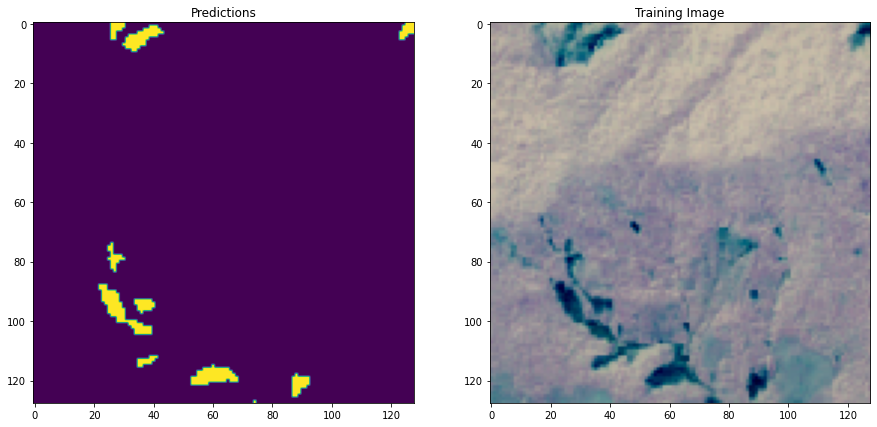

In [84]:
img = 167
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')